# Coregistering DEM data

> This notebook [is avaiable on GitHub here.](https://github.com/trchudley/pdemtools/blob/main/notebooks/coregistration.ipynb)

Rigorous DEM differencing necessitates coregistering scenes. `pdemtools` includes a couple of functions to make this quick and easy. A simple method of coregistration is provided, that of [Nuth and Kääb (2011)](https://doi.org/10.5194/tc-5-271-2011), with functions to correct your DEM against either a reference surface or ICESat-2 data. The Nuth and Kääb method accounts for translation errors only (i.e. x, y, and z offsets). For further options (e.g. rotation or tilt), it is worth consulting the [xdem package](https://xdem.readthedocs.io/en/latest/coregistration.html) for more in-depth options.

As usual, we will import `pdemtools`, in addition to the in-built `os` function for file management and `matplotlib` to plot our results in this notebook.


In [1]:
import os

import pdemtools as pdt

import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

We will also need to provide the local location of the Greenland BedMachine product. It does not need to be in any specific directory - just provide the complete filepath as a string.

In [2]:
bm_fpath = "/Users/tom/Library/CloudStorage/OneDrive-DurhamUniversity/data/bedmachine_5/BedMachineGreenland-v5.nc"

## Getting strips

We will once again grab some ArcticDEM strips to assess elevation change. This time, let's take a look at a subglacial lake drainage beneath Isunguata Sermia in West Greenland ([Livingstone _et al._, 2019](https://doi.org/10.5194/tc-13-2789-2019)). We will take two strips across a drainage event, coregistering them against each other using stable ground, and then using the ICESat-2 method.


In [3]:
bounds = -235000, -2499000, -222000, -2487000

We will exammine a drainage that took place in August 2019:

In [4]:
%%time

gdf = pdt.search(
    dataset='arcticdem',
    bounds = bounds, 
    years = 2019, 
    months = [6,7,8],
    baseline_max_hours = 24,
    sensors=['WV03', 'WV02', 'WV01'],
    accuracy=2,
    min_aoi_frac = 0.6,
)

if gdf is not None:
    print(f'{len(gdf)} strips found')

3 strips found
CPU times: user 65.4 ms, sys: 9.13 ms, total: 74.5 ms
Wall time: 1.14 s


In [5]:
gdf

,geometry,gsd,title,created,license,rmse,proj:code,published,is_lsf,proj:shape,...,href_hillshade,href_hillshade_masked,pdt_id,pdt_datetime1,pdt_datetime2,pdt_dem_baseline_hours,pdt_datetime_mean,pdt_year,pdt_month,pdt_aoi_frac
0,"POLYGON Z ((-233128 -2497824 0, -232352 -24891...",2.0,SETSM_s2s041_WV03_20190616_104001004D3CFC00_10...,2021-11-07T07:06:20Z,CC-BY-4.0,-9999,EPSG:3413,2022-09-22T06:12:13Z,True,"[6208, 7559]",...,https://pgc-opendata-dems.s3.us-west-2.amazona...,https://pgc-opendata-dems.s3.us-west-2.amazona...,SETSM_s2s041_WV03_20190616_104001004D3CFC00_10...,2019-06-16 15:20:00+00:00,2019-06-16 15:21:02+00:00,0.0,2019-06-16 15:20:31+00:00,2019,6,0.738371
1,"POLYGON Z ((-232856 -2498972 0, -232848 -24988...",2.0,SETSM_s2s041_WV03_20190811_104001005197F500_10...,2021-11-07T06:57:17Z,CC-BY-4.0,-9999,EPSG:3413,2022-09-22T06:12:14Z,True,"[6317, 7343]",...,https://pgc-opendata-dems.s3.us-west-2.amazona...,https://pgc-opendata-dems.s3.us-west-2.amazona...,SETSM_s2s041_WV03_20190811_104001005197F500_10...,2019-08-11 15:09:51+00:00,2019-08-11 15:10:42+00:00,0.0,2019-08-11 15:10:16.500000+00:00,2019,8,0.698926
2,"POLYGON Z ((-234446 -2487778 0, -234372.298 -2...",2.0,SETSM_s2s041_WV01_20190825_102001008C7F9500_10...,2021-11-07T07:03:56Z,CC-BY-4.0,-9999,EPSG:3413,2022-09-22T06:12:06Z,True,"[58747, 14836]",...,https://pgc-opendata-dems.s3.us-west-2.amazona...,https://pgc-opendata-dems.s3.us-west-2.amazona...,SETSM_s2s041_WV01_20190825_102001008C7F9500_10...,2019-08-25 18:21:10+00:00,2019-08-25 18:21:59+00:00,0.0,2019-08-25 18:21:34.500000+00:00,2019,8,0.986516



Elsewhere in these tutorials, we explored using the `pdt.load.preview` function to assess data quality, as well as downloading and saving scenes. We will skip previewing the scenes (spoilers: the two highest-quality strips are 2019-06-16 and 2019-08-25 at index  `0` and `2`), and compress our scene download into the following cell:


In [6]:
selected_scenes = [0, 2]
gdf_sel = gdf.iloc[selected_scenes]

date_1 = gdf_sel.iloc[[0]].pdt_datetime1.dt.date.values[0]
dem_id_1 = gdf_sel.iloc[[0]].pdt_id.values[0]

date_2 = gdf_sel.iloc[[1]].pdt_datetime1.dt.date.values[0]
dem_id_2 = gdf_sel.iloc[[1]].pdt_id.values[0]

output_directory = 'example_data'

if not os.path.exists(output_directory):
    os.mkdir(output_directory)

def get_scene(gdf_row, dem_id, output_directory):
    # Download and save, or load from saved if already downloaded.
    out_fpath = os.path.join(output_directory, f'{dem_id}.tif')
    if not os.path.exists(out_fpath):
        dem = pdt.load.from_search(gdf_row, bounds=bounds, bitmask=True, pad=True).compute()
        dem.rio.to_raster(out_fpath, compress='ZSTD', predictor=3, zlevel=1)
    else:
        dem = pdt.load.from_fpath(out_fpath, bounds=bounds, pad=True)
    return dem

print('Getting DEM 1')
dem_1 = get_scene(gdf_sel.iloc[[0]], dem_id_1, output_directory)

print('Getting DEM 2')
dem_2 = get_scene(gdf_sel.iloc[[1]], dem_id_2, output_directory)

print('Retrieved')

Getting DEM 1
Getting DEM 2
Retrieved


Great, let's quickly visualise these:

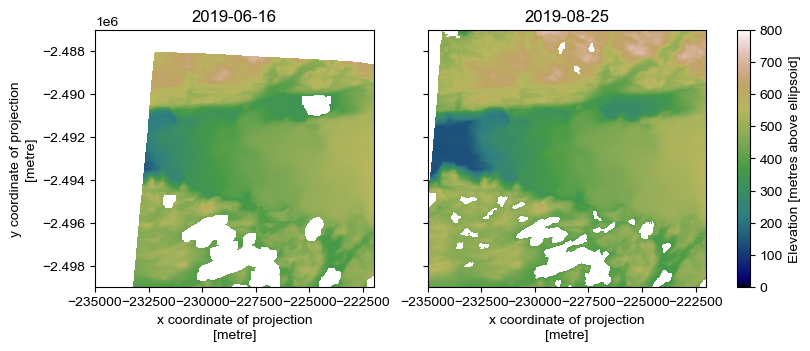

In [7]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,3.4))

ax = axes[0]
dem_1.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, add_colorbar=False)
ax.set_aspect('equal')
ax.set_title(date_1)

ax=axes[1]
dem_2.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
ax.set_aspect('equal')
ax.set_ylabel(None)
ax.set_title(date_2)

plt.show()

Note that these DEMs have some patches in them, but the important thing is that they're good quality across the glacier, and there's enough bare surface for coregistration!

## No coregistration

First, let's do a simple dem difference based upon the non-coregistered strips:

In [8]:
dz_no_coreg = dem_2 - dem_1

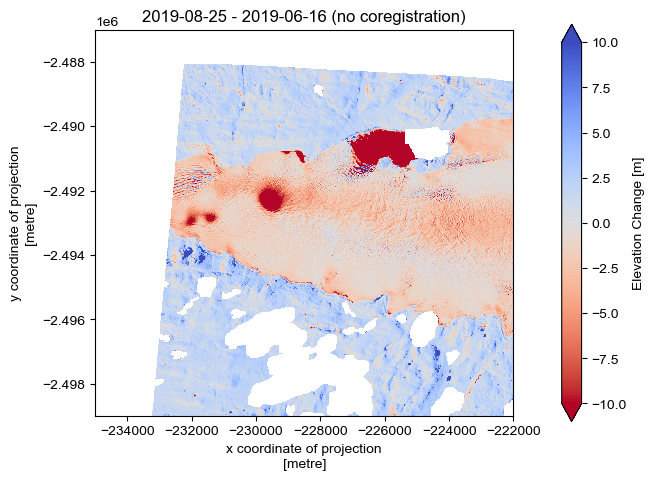

In [9]:
fig, ax = plt.subplots()
vrange = 10  # metres

dz_no_coreg.plot.imshow(ax=ax, cmap='coolwarm_r', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Elevation Change [m]'})

ax.set_title(f'{date_2} - {date_1} (no coregistration)')
ax.set_aspect('equal')

plt.show()

Because the changes are so large, it's still possible to visualise some of the features here. However, it is very messy and there is a clear systematic negative trend across the stable bedrock. As a result, any surface change measurements will contain a systematic offset. This offset is what coregistration aims to fix.

## Coregister based on stable ground

Now, let's coregister `dem_2` against `dem_1` using the stable bedrock. 

The [Nuth and Kääb (2011)](https://doi.org/10.5194/tc-5-271-2011) method is based around the fact that the offset between two DEMs is possible to estimate based on simple measurements. The first is a slope-dependent offset: the measured dZ over stable ground will be larger over regions of steeper slopes. The second is an aspect-dependent offset: for a shift in a single direction, the lee and stoss slopes will experience different dZ values, allowing the direction and magnitude of the horizontal offset to measured. By reconstructing the dX, dY, and dZ values against a reference dataset, we can 'coregister' the DEM to the reference.

In the first form of this method provided by `pdemtools`, we will coregister the two DEMs against each other based on the stable (i.e. non-glacial) ground they share. First, we must set a region of stable ground to coregister too. Around Antarctica and Greenland, we can base this on the bedrock mask included within BedMachine. The `data.bedrock_mask_from_bedmachine()` function makes this easy, as we will pull the bedrock mask from BedMachine and do all the necessary behind-the-scenes resampling:

In [10]:
bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bm_fpath, dem_1)

Then we can coregister `dem_2` against `dem_1` using the `.pdt.coregister()` function. This is based on code used in the PGC postprocessing pipeline, updated to utilise the updated pdemtools geomorphometric variable derivation.

In [11]:
dem_2_coreg_bedrock, metadata_coreg_bedrock = dem_2.pdt.coregister_dems(
    dem_1, 
    stable_mask=bedrock_mask, 
    return_stats=True,
)

Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 2.4997572898864746
Planimetric Correction Iteration 2
Offset (z,x,y): 1.727, 6.646, 2.250
Translating: 1.73 Z, 6.65 X, 2.25 Y
RMSE = 1.3887134790420532
Planimetric Correction Iteration 3
Offset (z,x,y): 1.736, 6.280, 2.071
Translating: 1.74 Z, 6.28 X, 2.07 Y
RMSE = 1.3855750560760498
Planimetric Correction Iteration 4
Offset (z,x,y): 1.736, 6.309, 2.089
Translating: 1.74 Z, 6.31 X, 2.09 Y
RMSE = 1.3856514692306519
RMSE step in this iteration (0.00008) is above threshold (-0.001), stopping and returning values of prior iteration.
Final offset (z,x,y): 1.736, 6.280, 2.071
Final RMSE = 1.3855750560760498


In this example, we have set the `return_stats` variable to `True`. This additionally return a metadata dictionary, which will allow us to inspect the final offsets and errors. If the coregistration fails for whatever reason (or, in some exceptions, only able to perform a vertical, rather than vertical and horizontal, correction) it will be recorded in the `coreg_status` parameter as `'failed`' or `'dz_only`' rather than `'coregistered'`:

In [12]:
metadata_coreg_bedrock

{'coreg_status': 'coregistered',
 'x_offset': 6.2799902856349945,
 'y_offset': 2.0714651346206665,
 'z_offset': 1.7363408440724015,
 'x_offset_err': 0.0032978144966238207,
 'y_offset_err': 0.002309573488523257,
 'z_offset_err': 0.0005464694888281476,
 'rmse': 1.3855750560760498,
 'coregistration_type': 'reference_dem'}

Sometimes, if one of the DEMs is smaller than the clip region, this can fail. If this is the case, try ‘padding’ the DEMs with NaN values to the full AOI, e.g.:

```
dem = dem.rio.pad_box(*bounds, constant_values=np.nan)
```

This can be done automatically within `load` module functions by setting `pad=True`.

Let’s compare and plot:

In [13]:
dz_coreg_bedrock = dem_2_coreg_bedrock - dem_1

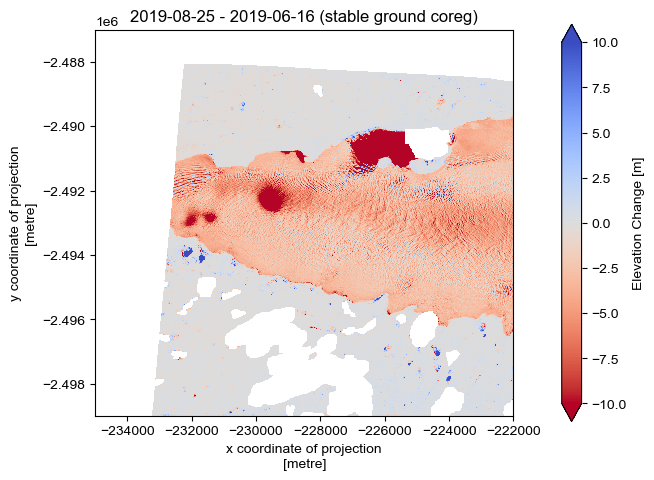

In [14]:

fig, ax = plt.subplots()
vrange = 10  # metres

dz_coreg_bedrock.plot.imshow(ax=ax, cmap='coolwarm_r', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Elevation Change [m]'})

ax.set_title(f'{date_2} - {date_1} (stable ground coreg)')
ax.set_aspect('equal')

plt.show()


This is much better. There are still 'spots' of blunders across the stable ground (this is often associated with steep slopes or, in particular in this dataset, the freeze-over of ponds and lakes), but where the surface is stable between the two scenes the bias is very low. You can clearly see the three centres of negative surface elevation change on the glacier surface - these are the subglacial lakes that have drained - as well as something indicative of the drainage channel along the central flow axis. You can even see that the outburst flood has eroded a channel in the proglacial environment!

## Coregistration based on ICESat-2

This is all very well and good, but these sort of features and dynamics [occur all across the ice sheet](https://doi.org/10.1038/s41467-019-10821-w), and won't always have some stable ground nearby for easy coregistration of ArcticDEM and REMA strips. Instead, ['inland' coregistration is often performed against satellite altimetry data](https://doi.org/10.3189/2013JoG12J114). 

Another option for coregistration is to use the same coregistration routine ([Nuth and Kääb, 2011](https://doi.org/10.5194/tc-5-271-2011)) but using [ICESat-2 altimetry](https://icesat-2.gsfc.nasa.gov/) data as the reference surface. `pdemtools` contains a wrapper function that automates the download and processing of ICESat-2 data using [sliderule](https://slideruleearth.io/) ([Shean et al. 2023](https://doi.org/10.21105/joss.04982)). This section outlines how to use this function to coregister ArcticDEM and REMA strip data.

> ⚠️
> **NOTE:** ICESat-2 started collecting data from the 14th October 2018, so it will not be useful in coregistering contemporaneous ice surface data before this point. However, ICESat-2 of any age could be used to coregister against stable off-ice regions if desired (for instance, if ArcticDEM or REMA mosaics are unavaiable or of poor quality for your area of interest).

### Download IS2

The `data` module has an `icesat2_atl06` function to enable easy download of suitable ICESat-2 over a given ArcticDEM or REMA strip. All you need to provide is the dem and the dem acquisition date.

ICESat-2 ATL06-SR is downloaded on the fly from sliderule [using the `sliderule` Python package](https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html). Compared to [standard processed ATL06 data](https://nsidc.org/data/atl06/versions/6), we request a higher resolution - a step distance of 10 metres with an extent length of 20 metres (`"res"=10`, `"len"=20`; versus the default 20 m and 40 m respectively). This allows us to better compare with ArcticDEM/REMA data, which we will downsample to 10 m for the coregistration process.

We will want to prioritise the ICESat-2 passes that are temporally closest in time. We first query all points within 7 days. If we can't find a requisite number of points overlapping valid pixels (by default, 50), we go on to query 14, 28, and 45 days. One complete ICESat-2 global repeat is 90 days long, so we really shouldn't need more than ±45 days. However, cloud is always a problem, so you can provide your own list of days to query through the `days_r` parameter is necessary. The geopandas dataframe that is returns also includes a custom `request_date_dt` column, so you can filter and make your own decisions on what ICESat-2 point to pass to the coregistration routine.

In [15]:
is2points_1 = pdt.data.icesat2_atl06(dem_1, date_1)

Querying points within 7 days... 32 points found with 15 intersecting dataset. Below minimum threshold (100). Expanding temporal search.
Querying points within 14 days... 32 points found with 15 intersecting dataset. Below minimum threshold (100). Expanding temporal search.
Querying points within 28 days... 305 points found with 141 intersecting dataset.


We can see what this looks like by plotting the ICESat-2 points over the DEM:

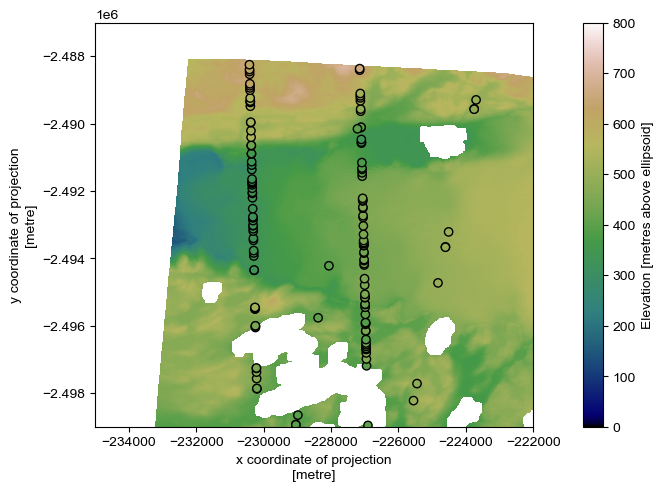

In [16]:
fix, ax = plt.subplots()

dem_1.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
is2points_1.plot(ax=ax, column='h_mean', cmap='gist_earth', vmin=0, vmax=800, ec='k', legend=False)
ax.set_title(None)

plt.show()

Let's do the same for the second image:

In [17]:
is2points_2 = pdt.data.icesat2_atl06(dem_2, date_2)

Querying points within 7 days... 10 points found with 4 intersecting dataset. Below minimum threshold (100). Expanding temporal search.
Querying points within 14 days... 38 points found with 29 intersecting dataset. Below minimum threshold (100). Expanding temporal search.
Querying points within 28 days... 99 points found with 77 intersecting dataset. Below minimum threshold (100). Expanding temporal search.
Querying points within 45 days... 99 points found with 77 intersecting dataset. Below minimum threshold (100). 

/Users/tom/Library/CloudStorage/OneDrive-DurhamUniversity/scripts/tools/pdemtools/src/pdemtools/data.py:345: UserWarning: Returning GeoDataFrame with number of points below minimum threshold.
  warnings.warn(


Note that we receive a warning that we haven't received the optimal number of points. An option in this situation could be to increase our temporal search range (e.g. add `days_r = 90` to extend the search range to 90 days). This will allow us to collect more ICESat-2 data, but a greater date range will mean that the the ICESat-2 ice surface will be increasingly different to the DEM ice surface. We can further get around this by introducing a `stable_mask` parameter to the `icesat2_atl06` function, if we have off-ice surface within our AOI. However, the whole point of this alternative method is to be able to explore regions away from stable ground. 

As a result, for this example, we take the pragmatic choice: accept that the total number is still pretty close to the minimum threshold, and move forward with a slightly non-optimal point cloud.

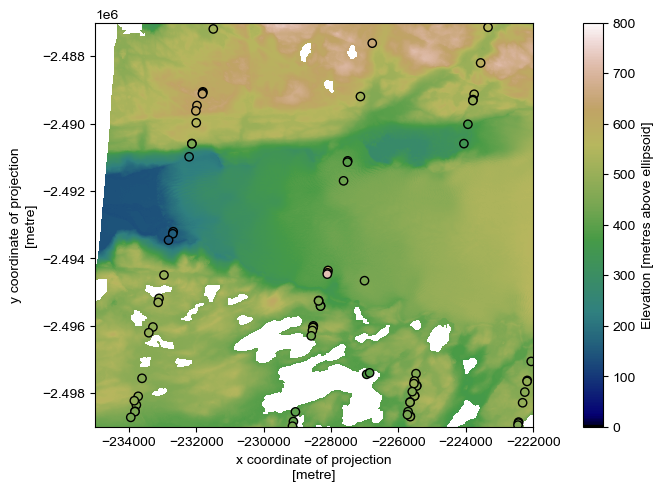

In [18]:

fix, ax = plt.subplots()

dem_2.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
is2points_2.plot(ax=ax, column='h_mean', cmap='gist_earth', vmin=0, vmax=800, ec='k', legend=False)

ax.set_title(None)

plt.show()


### Coregistration function

Our ICESat-2 coregistration function `pdt.coregister_is2()` operates largely the same as the `pdt.coregister_dem()` function, accepting largely the same parameters (and in fact both are a wrapper for an underlying coregistration function using the same maths).

One major difference is that the step distance for our ATLO6-SR data is 10 m resolution, a lower resolution than the 2 m reference DEM data. The 2 m resolution is redundant and perhaps disadvantageous for coregistration. Therefore, if the input DEM is < 10 m, it will be resampled to 10 m during the coregistration routine (these numbers can be changed in the more detailed parameters). The output will still be at the native resolution, however.

As we've seen this before, let's suppress the output using `verbose=False`.

In [19]:
from scipy import stats
from rasterio.enums import Resampling
import xarray as xr
import numpy as np

q_f = pdt._geomorphometry.q_f
p_f = pdt._geomorphometry.p_f
get_resolution = pdt._utils.get_resolution
interp2_gdal = pdt._coreg.interp2_gdal
shift_dem = pdt._coreg.shift_dem
interp2_fill_oob = pdt._coreg.interp2_fill_oob
interp_str2gdal = pdt._coreg.interp_str2gdal
dtype_np2gdal = pdt._coreg.dtype_np2gdal

def coregistericesat2(
    dem_rxr, 
    points_df, 
    mask_rxr=None, 
    res=2,
    max_horiz_offset=50,
    rmse_step_thresh=-0.001,
    max_iterations=5,
):

    # OUTSIDE WRAPPER
    dem_rxr = dem_rxr.squeeze()
    if mask_rxr is not None:
        mask_rxr = mask_rxr.squeeze()
    res = get_resolution(dem_rxr)

    # MAKE ADAPTABLE TO ANY RESOLUTION?
    # resample to 10 m resolution if less than:
    if res < 10:
        print("Resampling DEM to 10 m resolution for coregistration process...")
        resampled = True
        dem_rxr_in = dem_rxr.rio.reproject(
            dem_rxr.rio.crs,  # Maintain the original coordinate reference system
            resolution = 10,  # Set the target resolution to 10 meters
            resampling = Resampling.average, # Upscale with average resampling method
        )
        if mask_rxr is not None:
            mask_rxr_in = mask_rxr.rio.reproject(mask_rxr.rio.crs, resolution=10, resampling=Resampling.nearest)
    else:
        resampled = False
        dem_rxr_in = dem_rxr
    
    # create sample
    dem2 = dem_rxr_in.values
    zero_xda = (dem_rxr_in * 0).copy()
    x = dem_rxr_in.x.values
    y = dem_rxr_in.y.values
    res = get_resolution(dem_rxr_in)

    # # get unfiltered coords
    # coords_ds = xr.Dataset({
    #     "x": (["points"], points_df.geometry.x.values), 
    #     "y": (["points"], points_df.geometry.y.values),
    # })

    # # get dem2 and mask values
    # if mask_rxr is not None:
    #     mask = mask_rxr_in.values
    #     points_df['mask_vals'] = mask_rxr_in.interp(coords_ds, method='nearest').values
    #     points_df = points_df[points_df.mask_vals != 0]

    # Get unfiltered coords list
    coords_ds = xr.Dataset({
        "x": (["points"], points_df.geometry.x.values), 
        "y": (["points"], points_df.geometry.y.values),
    })

    # Determine raster value and mask at each point
    points_df['init_values'] = dem_rxr_in.interp(coords_ds, method='linear').values
    if mask_rxr is not None:
        points_df['mask'] = mask_rxr_in.interp(coords_ds, method='nearest').values        

    # Filter values at each point
    points_df = points_df[~points_df['init_values'].isnull()]
    if mask_rxr is not None:
        points_df = points_df[points_df['mask'] > 0]

    # Get filtered coordinates list
    coords_ds = xr.Dataset({
        "x": (["points"], points_df.geometry.x.values), 
        "y": (["points"], points_df.geometry.y.values),
    })
    
    # get point height values
    points_h = points_df.h_mean.values

    # get number of point used to coregister
    points_n = len(points_df)
    
    # initial trans and RMSE settings
    p = np.zeros((3, 1))  # p  is prior iteration trans var
    pn = p.copy()  # pn is current iteration trans var
    perr = np.zeros((3, 1))  # perr is prior iteration regression errors
    pnerr = perr.copy()  # pnerr is current iteration regression errors
    d0 = np.inf  # initial RMSE

    # Edge case markers
    meddz = None
    return_meddz = False
    critical_failure = False
    
    it = 0
    
    while True:
        it += 1
        print(f"Planimetric Correction Iteration {it}")

        print(f"Offset (z,x,y): {pn[0, 0]:.3f}, {pn[1, 0]:.3f}, {pn[2, 0]:.3f}")
        # print(f"pn: {pn}")

        # Break loop if conditions reached
        if np.any(np.abs(pn[1:]) > max_horiz_offset):
            print(
                f"Maximum horizontal offset ({max_horiz_offset}) exceeded. "
                "Consider raising the threshold if offsets are large."
            )
            return_meddz = True
            break

        # Apply offsets
        if pn[1] != 0 and pn[2] != 0:
            dem2n = shift_dem(dem2, pn.T[0], x, y).astype('float32')
        else:
            dem2n = dem2 - pn[0].astype('float32')

        # # Calculate slopes - original method from PGC
        # sy, sx = np.gradient(dem2n, res)
        # sx = -sx

        # Calculate slope - using Florinsky slope method (p = sx, q = sy)
        sy = q_f(dem2n, res)
        sx = p_f(dem2n, res)
        sy = -sy
        sx = -sx

        # Get relevant dz, sy, sx values at the icesat-2 coordinates
        xda = zero_xda + dem2n
        dem2n_coords = xda.interp(coords_ds, method='linear').values
        dz = dem2n_coords - points_h
        
        xda = zero_xda + sy
        sy = xda.interp(coords_ds, method='linear').values
        
        xda = zero_xda + sx
        sx = xda.interp(coords_ds, method='linear').values
        
        # If no overlap between scenes, break the loop
        if np.all(np.isnan(dz)):
            print("No overlap between ICESat-2 data and DEM.")
            critical_failure = True
            break
            
        # Filter NaNs and outliers.
        n = (
            ~np.isnan(sx)
            & ~np.isnan(sy)
            & (np.abs(dz - np.nanmedian(dz)) <= 3 * np.nanstd(dz))
        )
        # print(n)
        n_count = np.count_nonzero(n)
        # print(n_count)

        if n_count < 10:
            print("Too few ({}) registration points: 10 required".format(n_count))
            critical_failure = True
            break

        # Get RMSE
        d1 = np.sqrt(np.mean(np.power(dz[n], 2)))
        print("RMSE = {}".format(d1))
        
        # Keep median dz if first iteration.
        if it == 1:
            meddz = np.median(dz[n])
            meddz_err = np.std(dz[n] / np.sqrt(n_count))
            d00 = np.sqrt(np.mean(np.power(dz[n] - meddz, 2)))

        # Get improvement in RMSE
        rmse_step = d1 - d0  # initial d0 == inf

        # break if rmse above threshold
        if rmse_step > rmse_step_thresh or np.isnan(d0):
            print(
                "RMSE step in this iteration ({:.5f}) is above threshold ({}), "
                "stopping and returning values of prior iteration. ".format(
                    rmse_step, rmse_step_thresh
                )
            )
            # If fails after first registration attempt,
            # set dx and dy to zero and subtract the median offset.
            if it == 2:
                print("Second iteration regression failure")
                return_meddz = True
            break
        elif it == max_iterations:
            print("Maximum number of iterations ({}) reached".format(max_iterations))
            break

        # Keep this adjustment.
        dem2out = dem2n.copy()
        p = pn.copy()
        perr = pnerr.copy()
        d0 = d1

        # Build design matrix.
        X = np.column_stack((np.ones(n_count, dtype=np.float32), sx[n], sy[n]))
        sx, sy = None, None  # release for data amangement

        # Solve for new adjustment.
        p1 = np.reshape(np.linalg.lstsq(X, dz[n], rcond=None)[0], (-1, 1))

        # Calculate p errors.
        _, R = np.linalg.qr(X)
        RI = np.linalg.lstsq(R, np.identity(3, dtype=np.float32), rcond=None)[0]
        nu = X.shape[0] - X.shape[1]  # residual degrees of freedom
        yhat = np.matmul(X, p1)  # predicted responses at each data point
        r = dz[n] - yhat.T[0]  # residuals
        normr = np.linalg.norm(r)

        dz = None  # release for memory managment

        rmse = normr / np.sqrt(nu)
        tval = stats.t.ppf((1 - 0.32 / 2), nu)

        se = rmse * np.sqrt(np.sum(np.square(np.abs(RI)), axis=1, keepdims=True))
        p1err = tval * se

        # Update shifts.
        pn = p + p1
        pnerr = np.sqrt(np.square(perr) + np.square(p1err))

        # END OF LOOP
    
    if return_meddz:
        print("Returning median vertical offset: {:.3f}".format(meddz))
        dem2out = dem2 - meddz
        p = np.array([[meddz, 0, 0]]).T
        perr = np.array([[meddz_err, 0, 0]]).T
        d0 = d00
        status = "dz_only"

    elif critical_failure:
        print("Regression critical failure, returning original image, NaN trans, and RMSE")
        dem2out = dem2
        p = np.full((3, 1), np.nan)
        perr = np.full((3, 1), np.nan)
        d0 = np.nan
        status = "failed"

    else:
        status = "coregistered"

    if resampled: 
        # If the coregistration estimation has been run on a DEM that has been upsampled to 10 m,
        # we have to apply the calculated offsets to original high-resolution image
        if critical_failure:
            dem2out = dem_rxr.values.astype('float32')  
        print("Applying coregistration transform to original image...")
        if return_meddz:
            dem2out = dem_rxr.values - meddz.astype('float32')  
        else:
            # Apply offsets
            if pn[1] != 0 and pn[2] != 0:
                dem2out = shift_dem(dem_rxr.values, p.T[0], dem_rxr.x.values, dem_rxr.y.values).astype('float32')
            else:
                dem2out = dem_rxr.values - pn[0].astype('float32')  
            dem_rxr = (dem_rxr*0) + dem2out
    else:
        dem_rxr = (dem_rxr*0) + dem2out

    print(
        "Final offset (z,x,y): {:.3f}, {:.3f}, {:.3f}".format(p[0, 0], p[1, 0], p[2, 0])
    )
    print("Final RMSE = {}".format(d0))


    # pdt-specific icesat-2 metadata
    if 'request_date_dt' in points_df.columns:
        dt_days = points_df['request_date_dt'].dt.round('d').dt.days
        dt_days_counts_dict = dt_days.value_counts().to_dict()

    # Construct metadata:
    metadata_dict = {
        "coreg_status": status,
        "x_offset": p[1, 0],
        "y_offset": p[2, 0],
        "z_offset": p[0, 0],
        "x_offset_err": perr[1, 0],
        "y_offset_err": perr[2, 0],
        "z_offset_err": perr[0, 0],
        "rmse": d0,
        "points_n": points_n,
        "points_dt_days_count": dt_days_counts_dict,
    }
    
    # Convert all numerical values to regular Python floats
    metadata_dict = {
        key: float(value) if isinstance(value, (np.float64, np.float32)) else value
        for key, value in metadata_dict.items()
    }

    
    return dem_rxr, metadata_dict


In [20]:
dem_1_coreg_is2, dem_1_coreg_is2_metadata = dem_1.pdt.coregister_is2(
    is2points_1, 
    return_stats=True,
    verbose=False,
)

No `stable_mask` provided: assuming entire scene is suitable reference surface.
Upsampling 2.0 m DEM to 10 m resolution for coregistration process...
Final offset (z,x,y): -0.985, -1.628, -0.807
Final RMSE = 0.7749522310917916
Applying transform to original image...
Translating: -0.99 Z, -1.63 X, -0.81 Y


In [21]:
dem_2_coreg_is2, dem_2_coreg_is2_metadata = dem_2.pdt.coregister_is2(
    is2points_2, 
    return_stats=True,
    verbose=False,
)

No `stable_mask` provided: assuming entire scene is suitable reference surface.
Upsampling 2.0 m DEM to 10 m resolution for coregistration process...
Final offset (z,x,y): 0.997, 1.244, 0.436
Final RMSE = 1.3319617245141544
Applying transform to original image...
Translating: 1.00 Z, 1.24 X, 0.44 Y


Our new metadata countains three additional variables: `points_n`, the number of points used for coregistration; `points_dt_days_max`, the maximum number of days between the DEM and ICESat-2 dates; and `points_dt_days_count`, a dictionary where the keys represent the temporal offset from the DEM date in days, and the values represent the number of points that have that temporal offset.

In [22]:
dem_2_coreg_is2_metadata

{'coreg_status': 'coregistered',
 'x_offset': 1.2438564308904818,
 'y_offset': 0.4361289204786737,
 'z_offset': 0.9966485479070465,
 'x_offset_err': 2.056510690289901,
 'y_offset_err': 1.164318741484589,
 'z_offset_err': 0.23018213974842833,
 'rmse': 1.3319617245141544,
 'points_n': 76,
 'points_dt_days_max': 19,
 'points_dt_days_count': {19: 48, -10: 25, 1: 4},
 'coregistration_type': 'reference_icesat2'}

These additional matadata variables could be used for additional first-order QA of batch-processed output.

Let's now plot our DEM difference:

In [23]:
dz_coreg_is2 = dem_2_coreg_is2 - dem_1_coreg_is2

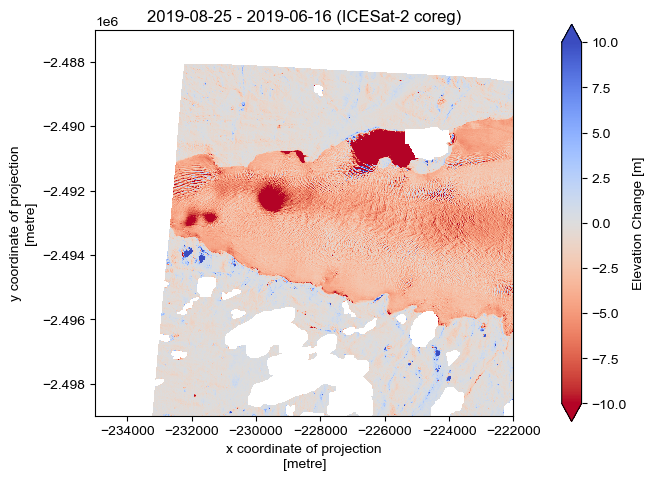

In [24]:

fig, ax = plt.subplots()
vrange = 10 # metres

dz_coreg_is2.plot.imshow(ax=ax, cmap='coolwarm_r', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Elevation Change [m]'})

ax.set_title(f'{date_2} - {date_1} (ICESat-2 coreg)')
ax.set_aspect('equal')

plt.show()


This provides a reasonable coregistration. The quality isn't quite as high as the off-ice coregistration due to a lower number of points from `dem_2`. However, with higher numbers of coregistration points (>200), the quality can be on par with DEM-based coregistration. The risk of slightly lower quality coregistration based around non-optimal point quantity and distribution is offset by the ability to extend coregistration capabilities far from stable ground, into the ice sheet interiors.